ERROR 1: PROJ: internal_proj_create_from_database: /Users/sumitchand/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


CRSError: The WKT could not be parsed. OGR Error code 6

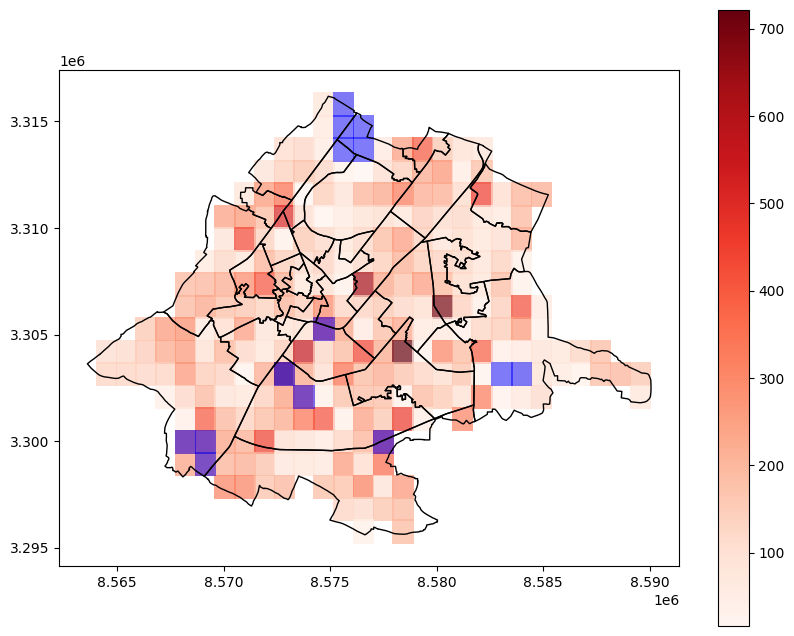

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from rasterio.transform import xy
from scipy.spatial import cKDTree
import contextily as ctx
from sklearn.cluster import DBSCAN
from esda.moran import Moran_Local
import libpysal


def load_raster(tif_path):
    """Load raster data and return array and metadata."""
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
    return data, transform, crs


def load_shapefile(shp_path):
    """Load shapefile as a GeoDataFrame."""
    return gpd.read_file(shp_path)


def reproject_shapefile(gdf, target_crs):
    """Reproject shapefile to match the target CRS."""
    if gdf.crs != target_crs:
        return gdf.to_crs(target_crs)
    return gdf


def create_polygons_from_grid(df_grid, cell_size=0.009):
    """Create polygons from grid points with a given cell size."""
    polygons = [
        Polygon([
            (row["Longitude"] - cell_size / 2, row["Latitude"] - cell_size / 2),
            (row["Longitude"] + cell_size / 2, row["Latitude"] - cell_size / 2),
            (row["Longitude"] + cell_size / 2, row["Latitude"] + cell_size / 2),
            (row["Longitude"] - cell_size / 2, row["Latitude"] + cell_size / 2)
        ]) for _, row in df_grid.iterrows()
    ]
    return gpd.GeoDataFrame(df_grid, geometry=polygons, crs="EPSG:4326")


def plot_hotspots(gdf_polygons, gurugram):
    """Perform DBSCAN clustering and Local Moran's I analysis to identify PM2.5 hotspots."""
    pm25_threshold = 60
    coordinates = np.array(list(zip(gdf_polygons.geometry.centroid.x, gdf_polygons.geometry.centroid.y)))
    
    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.005, min_samples=5)
    gdf_polygons['Cluster'] = dbscan.fit_predict(coordinates)
    gdf_polygons['Hotspot'] = (gdf_polygons['PM2.5'] > pm25_threshold) & (gdf_polygons['Cluster'] != -1)
    
    # Local Moran's I
    w = libpysal.weights.KNN.from_dataframe(gdf_polygons, k=5)
    moran_local = Moran_Local(gdf_polygons['PM2.5'], w)
    gdf_polygons['Local_Moran'] = moran_local.Is
    gdf_polygons['Hotspot'] |= gdf_polygons['Local_Moran'] > 1
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf_polygons.plot(column="PM2.5", cmap="Reds", alpha=0.7, legend=True, ax=ax)
    gdf_polygons[gdf_polygons['Hotspot']].plot(ax=ax, color="blue", alpha=0.5, legend=True)
    gurugram.boundary.plot(ax=ax, color="black", linewidth=1)
    ctx.add_basemap(ax, crs=gdf_polygons.crs, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title("Spatial Distribution of PM2.5 Hotspots", fontsize=14)
    plt.show()


if __name__ == "__main__":
    tif_path = "/Users/sumitchand/Downloads/ind_ppp_2020_1km_Aggregated.tif"
    shp_path = "/Users/sumitchand/Downloads/Gurugram_ward.shp"
    clipped_tif_path = "/Users/sumitchand/Downloads/population_gurugram.tif"
    
    population_data, pop_transform, pop_crs = load_raster(tif_path)
    gurugram = load_shapefile(shp_path)
    gurugram = reproject_shapefile(gurugram, pop_crs)
    
    # Load grid data (assumed preprocessed)
    df_grid = pd.read_csv("/Users/sumitchand/Downloads/population_interpolated_pm25.csv")
    gdf_polygons = create_polygons_from_grid(df_grid).to_crs("EPSG:3857")
    gurugram = gurugram.to_crs("EPSG:3857")
    
    plot_hotspots(gdf_polygons, gurugram)
